In [ ]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# Install PySpark
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
# Read in csv data files from github (https://github.com/tcox17/Bachelor_Project/tree/main/Original%20Datasets by  Taylor Cox & Connor Derrick )
bachelors_df = pd.read_csv("https://raw.githubusercontent.com/tcox17/Bachelor_Project/c00761f14bf55f4aa0886b6584ec0621bed2826f/Original%20Datasets/bachelors.csv")
contestants_df = pd.read_csv("https://raw.githubusercontent.com/tcox17/Bachelor_Project/c00761f14bf55f4aa0886b6584ec0621bed2826f/Original%20Datasets/bachelor-contestants.csv")


In [ ]:
# Change datatypes of columns
bachelors_df['Name'] = bachelors_df['Name'].astype('string')
bachelors_df['Hometown'] = bachelors_df['Hometown'].astype('string')


In [ ]:
# Clean Bachelor dataframe
# Drop Height column
bachelors_df.drop(['Height'], axis=1, inplace=True)

# Split Hometown to get city and state/country
bachelors_df[['City', 'State/Country']] = bachelors_df['Hometown'].str.split(',', n=1, expand=True)
bachelors_df.drop(['Hometown'], axis=1, inplace=True)



In [ ]:
# Reindex with season number
bachelors_df.set_index('Season', inplace=True)
bachelors_df

,Name,Age,City,State/Country
Season,,,,
1,Alex Michel,32,Charlottesville,Virginia
2,Aaron Buerge,28,Butler,Missouri
5,Jesse Palmer,34,Toronto,Ontario
9,Lorenzo Borghese,34,Milan,Italy
10,Andy Baldwin,30,Lancaster,Pennsylvania
11,Brad Womack,35,Austin,Texas
12,Matt Grant,27,London,England
13,Jason Mesnick,33,Cleveland,Ohio
14,Jake Pavelka,32,Dallas,Texas


In [ ]:
contestants_df

,Name,Age,Occupation,Hometown,Height,ElimWeek,Season
0,Amanda Marsh,23.0,Event Planner,"Chanute, Kansas",NaN,NaN,1
1,Trista Rehn,29.0,Miami Heat Dancer,"Miami, Florida",NaN,6.0,1
2,Shannon Oliver,24.0,Financial Management Consultant,"Dallas, Texas",NaN,5.0,1
3,Kim,24.0,Nanny,"Tempe, Arizona",NaN,4.0,1
4,Cathy Grimes,22.0,Graduate Student,"Terra Haute, Indiana",NaN,3.0,1
...,...,...,...,...,...,...,...
418,Sarah,26.0,Grade School Teacher,"Newport Beach, CA",65.0,4.0,21
419,Susannah,26.0,Account Manager,"San Diego, CA",66.0,1.0,21
420,Taylor,23.0,Mental Health Counselor,"Seattle, WA",64.0,5.0,21
421,Vanessa,29.0,Special Education Teacher,"Montreal, Quebec, Canada",63.5,NaN,21


In [ ]:
# Clean contestant dataframe
# Drop Height and Occupation columns
contestants_df.drop(['Height','Occupation'], axis=1, inplace=True)
contestants_df.head()

,Name,Age,Hometown,ElimWeek,Season
0,Amanda Marsh,23.0,"Chanute, Kansas",NaN,1
1,Trista Rehn,29.0,"Miami, Florida",6.0,1
2,Shannon Oliver,24.0,"Dallas, Texas",5.0,1
3,Kim,24.0,"Tempe, Arizona",4.0,1
4,Cathy Grimes,22.0,"Terra Haute, Indiana",3.0,1


In [ ]:
# Check for missing values (nan is expected in elimination week as that indicates a winner who was never eliminated)
contestants_df.count()

Name        423
Age         422
Hometown    423
ElimWeek    406
Season      423
dtype: int64

In [ ]:
# drop the row with a missing age value
contestants_df = contestants_df.dropna(subset=['Age'])

contestants_df.count()

Name        422
Age         422
Hometown    422
ElimWeek    405
Season      422
dtype: int64

In [ ]:
# reset index after dropping a row
contestants_df = contestants_df.reset_index(drop=True)

In [ ]:
# Fill in nan value in Elimination week with 0 to indicated they never went home
contestants_df['ElimWeek'].fillna(0, inplace=True)
contestants_df.count()

Name        422
Age         422
Hometown    422
ElimWeek    422
Season      422
dtype: int64

In [ ]:
# Change column datatypes
contestants_df = contestants_df.astype({'Name' : 'string',
                                        'Age' : 'int64',
                                        'Hometown' : 'string',
                                        'ElimWeek' : 'int64'})


In [ ]:
contestants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      422 non-null    string
 1   Age       422 non-null    int64 
 2   Hometown  422 non-null    string
 3   ElimWeek  422 non-null    int64 
 4   Season    422 non-null    int64 
dtypes: int64(3), string(2)
memory usage: 16.6 KB


In [ ]:
# Split hometown into city, state, country
contestants_df[['City', 'State', 'Country']] = contestants_df['Hometown'].str.split(',', n=2, expand=True)
contestants_df.drop(['Hometown'], axis=1, inplace=True)

In [ ]:
# The last set of contestants uses a different format for state names which will have to be changed
contestants_df.tail(40)

,Name,Age,ElimWeek,Season,City,State,Country
382,"Jacqueline ""Jackie"" Dion",23,2,20,Newport Beach,California,<NA>
383,Samantha Passmore,26,2,20,New Smyrna Beach,Florida,<NA>
384,"Lauren ""LB"" Barr",23,2,20,Stillwater,Oklahoma,<NA>
385,Breanne Rice,30,1,20,Seattle,Washington,<NA>
386,"Isabel ""Izzy"" Goodkind",24,1,20,Branford,Connecticut,<NA>
387,Jessica Moser,23,1,20,Boca Raton,Florida,<NA>
388,Laura Esselman,24,1,20,Louisville,Kentucky,<NA>
389,Lauren Russell,26,1,20,Houston,Texas,<NA>
390,Maegan Miller,30,1,20,Visalia,California,<NA>
391,Tiara Soleim,27,1,20,Redmond,Washington,<NA>


In [ ]:
# State name to abbreviation dictionary sourced from: https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/ credited to Mike Schultz
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

contestants_df['State'] = contestants_df['State'].replace(regex = states)


In [ ]:
# replace any abbreviations in the bachelor df with full state names
bachelors_df['State/Country'] = bachelors_df['State/Country'].replace(regex = states)

In [ ]:
contestants_df.tail(40)

,Name,Age,ElimWeek,Season,City,State,Country
382,"Jacqueline ""Jackie"" Dion",23,2,20,Newport Beach,California,<NA>
383,Samantha Passmore,26,2,20,New Smyrna Beach,Florida,<NA>
384,"Lauren ""LB"" Barr",23,2,20,Stillwater,Oklahoma,<NA>
385,Breanne Rice,30,1,20,Seattle,Washington,<NA>
386,"Isabel ""Izzy"" Goodkind",24,1,20,Branford,Connecticut,<NA>
387,Jessica Moser,23,1,20,Boca Raton,Florida,<NA>
388,Laura Esselman,24,1,20,Louisville,Kentucky,<NA>
389,Lauren Russell,26,1,20,Houston,Texas,<NA>
390,Maegan Miller,30,1,20,Visalia,California,<NA>
391,Tiara Soleim,27,1,20,Redmond,Washington,<NA>


In [ ]:
# We only want one location to use for matching later on so copy state names to 'country' column
contestants_df['Country'] = contestants_df['Country'].fillna(contestants_df['State'])

# Rename 'country' to 'state/country'
contestants_df = contestants_df.rename(columns={'Country' : 'State/Country'})

# Drop the City and State columns
contestants_df.drop(['City' ,'State'], axis=1, inplace=True)

contestants_df

,Name,Age,ElimWeek,Season,State/Country
0,Amanda Marsh,23,0,1,Kansas
1,Trista Rehn,29,6,1,Florida
2,Shannon Oliver,24,5,1,Texas
3,Kim,24,4,1,Arizona
4,Cathy Grimes,22,3,1,Indiana
...,...,...,...,...,...
417,Sarah,26,4,21,California
418,Susannah,26,1,21,California
419,Taylor,23,5,21,Washington
420,Vanessa,29,0,21,Canada


In [ ]:
bachelors_df

,Name,Age,City,State/Country
Season,,,,
1,Alex Michel,32,Charlottesville,Virginia
2,Aaron Buerge,28,Butler,Missouri
5,Jesse Palmer,34,Toronto,Ontario
9,Lorenzo Borghese,34,Milan,Italy
10,Andy Baldwin,30,Lancaster,Pennsylvania
11,Brad Womack,35,Austin,Texas
12,Matt Grant,27,London,England
13,Jason Mesnick,33,Cleveland,Ohio
14,Jake Pavelka,32,Dallas,Texas


In [ ]:
# Calculate age difference between the bachelor of the season and all the contestants and if they are younger than their bachelor

# create lists to hold data to be added in new columns later
age_difference=[]
younger=[]

# for loop: for each row in the dataframe
for i in range(len(contestants_df)):
  # store contestant age
  current_age = contestants_df.loc[i, 'Age']
  #print(current_age)
  # generate season variable
  current_season = contestants_df.loc[i, 'Season']

  # match season with the bachelor from bachelors_df and get age
  bach_age = bachelors_df.loc[bachelors_df.index == current_season, 'Age'].iloc[0]

  # subtract contestant age from bachelor age
  current_diff = bach_age - current_age

  # determine if the contestant is younger or not
  if current_diff <= 0:
    # if the difference is 0 or negative, contestant is not younger so enter 0
    younger.append(0)
  # else contestant is younger, put a 1 in 'younger' column
  else:
    younger.append(1)

  # put the age difference in the created list
  age_difference.append(current_diff)


# add the two new lists to the dataframe
contestants_df['Age Difference'] = age_difference
contestants_df['Younger'] = younger


In [ ]:
# Determine if the contestants are from the same state or country (outside USA) as their bachelor

# Create list to hold an indicator of location match
same_home = []

# for loop: for each row in contestants
for i in range(len(contestants_df)):

  # Store contestant home
  current_home = contestants_df.loc[i, 'State/Country']

  # Store bachelor home
  bach_home = bachelors_df.loc[bachelors_df.index == current_season, 'State/Country'].iloc[0]

  # See if the homes match
  if current_home == bach_home:
    # if they match, put 1 in the same_home list
    same_home.append(1)
  else:
    # if they don't match, put 0 in same_home list
    same_home.append(0)

# add the list as a new column in contestant dataframe
contestants_df['Same Home'] = same_home
contestants_df.head()


,Name,Age,ElimWeek,Season,State/Country,Age Difference,Younger,Same Home
0,Amanda Marsh,23,0,1,Kansas,9,1,0
1,Trista Rehn,29,6,1,Florida,3,1,0
2,Shannon Oliver,24,5,1,Texas,8,1,0
3,Kim,24,4,1,Arizona,8,1,0
4,Cathy Grimes,22,3,1,Indiana,10,1,0


In [ ]:
contestants_df.head()

,Name,Age,ElimWeek,Season,State/Country,Age Difference,Younger,Same Home
0,Amanda Marsh,23,0,1,Kansas,9,1,0
1,Trista Rehn,29,6,1,Florida,3,1,0
2,Shannon Oliver,24,5,1,Texas,8,1,0
3,Kim,24,4,1,Arizona,8,1,0
4,Cathy Grimes,22,3,1,Indiana,10,1,0


In [ ]:
# Output the cleaned data as a csv file
contestants_df.to_csv('Cleaned_contestant_data.csv')

In [ ]:
#Decision Tree Modelling

In [ ]:
# Create a new DataFrame without the 'Name' and 'State' columns
contestants_df_DT = contestants_df.drop(columns=['Name', 'State/Country'])

# Display the new DataFrame
print(contestants_df_DT)



     Age  ElimWeek  Season  Age Difference  Younger  Same Home
0     23         0       1               9        1          0
1     29         6       1               3        1          0
2     24         5       1               8        1          0
3     24         4       1               8        1          0
4     22         3       1              10        1          0
..   ...       ...     ...             ...      ...        ...
417   26         4      21              10        1          0
418   26         1      21              10        1          0
419   23         5      21              13        1          0
420   29         0      21               7        1          0
421   25         6      21              11        1          0

[422 rows x 6 columns]


Mean Squared Error: 7.809716503267974
R2 Score: -0.34262603474304276


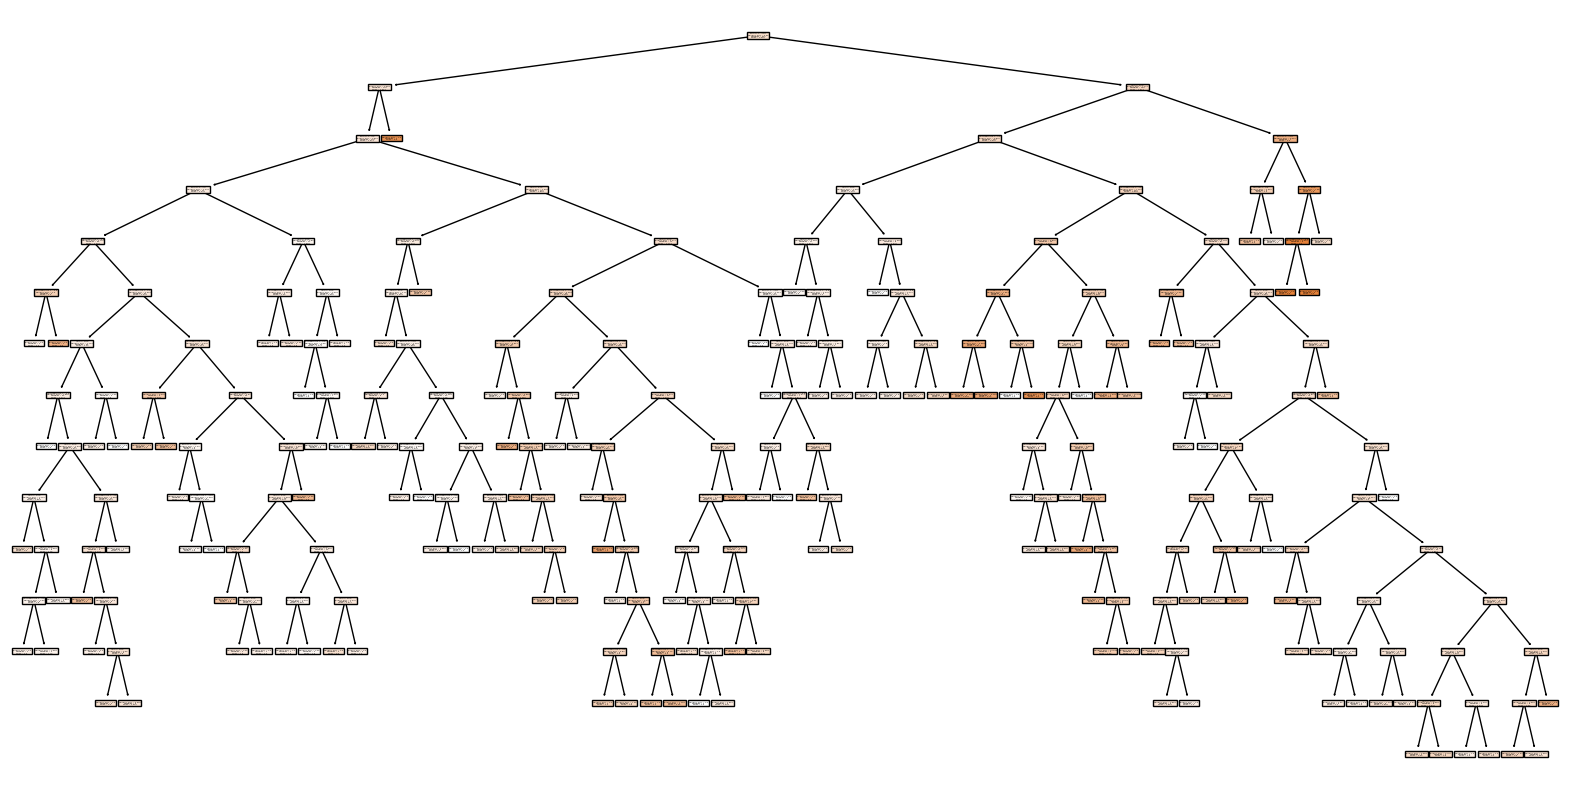

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Define features (X) and target (y)
X = contestants_df_DT[['Age', 'Season', 'Age Difference', 'Younger', 'Same Home']]
y = contestants_df_DT['ElimWeek']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree regressor
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Predict the 'ElimWeek' using the trained model
y_pred = regressor.predict(X_test)

# Evaluate the Decision Tree's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

# Visualize the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()


In [ ]:
# Predict the 'ElimWeek' for the entire DataFrame
contestants_df_DT['Predicted_ElimWeek'] = regressor.predict(X)

# Display the DataFrame with the predictions
contestants_df_DT


,Age,ElimWeek,Season,Age Difference,Younger,Same Home,Predicted_ElimWeek
0,23,0,1,9,1,0,2.500000
1,29,6,1,3,1,0,2.666667
2,24,5,1,8,1,0,4.500000
3,24,4,1,8,1,0,4.500000
4,22,3,1,10,1,0,2.000000
...,...,...,...,...,...,...,...
417,26,4,21,10,1,0,2.666667
418,26,1,21,10,1,0,2.666667
419,23,5,21,13,1,0,3.250000
420,29,0,21,7,1,0,1.000000


In [ ]:
#Regression Modelling

In [ ]:
contestants_df['winner'] = np.where(contestants_df['ElimWeek'] ==0, 1, 0)
contestants_df[contestants_df['winner']==0]

,Name,Age,ElimWeek,Season,State/Country,Age Difference,Younger,Same Home,winner
1,Trista Rehn,29,6,1,Florida,3,1,0,0
2,Shannon Oliver,24,5,1,Texas,8,1,0,0
3,Kim,24,4,1,Arizona,8,1,0,0
4,Cathy Grimes,22,3,1,Indiana,10,1,0,0
5,Christina,28,3,1,California,4,1,0,0
...,...,...,...,...,...,...,...,...,...
414,Olivia,25,1,21,Alaska,11,1,0,0
417,Sarah,26,4,21,California,10,1,0,0
418,Susannah,26,1,21,California,10,1,0,0
419,Taylor,23,5,21,Washington,13,1,0,0


In [ ]:
X = contestants_df.drop(columns=["Name","ElimWeek","Season","State/Country","winner"])
y = contestants_df["winner"]
X
y

0      1
1      0
2      0
3      0
4      0
      ..
417    0
418    0
419    0
420    1
421    0
Name: winner, Length: 422, dtype: int64

In [ ]:
X_train, X_test ,y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape
X_train

,Age,Age Difference,Younger,Same Home
113,26,4,1,0
213,29,3,1,0
97,25,9,1,0
221,24,8,1,0
416,25,11,1,0
...,...,...,...,...
312,29,3,1,0
25,27,1,1,0
364,25,1,1,0
14,27,5,1,0


In [ ]:
# Create a logistic regression classifier.
classifier = LogisticRegression(solver='lbfgs',
                                max_iter =200,
                                random_state=1)
classifier

LogisticRegression(max_iter=200, random_state=1)

In [ ]:
# Train the model
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [ ]:
# Get the training and testing data score.
print(f"Training Data Score: {classifier.score(X_train,y_train)}")
print(f"Testing Data Score: {classifier.score(X_test,y_test)}")

Training Data Score: 0.9588607594936709
Testing Data Score: 0.9622641509433962


In [ ]:
# Make predictions.
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions,"Actual": y_test}).reset_index(drop=True)
results

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
101,0,0
102,0,0
103,0,1
104,0,0


In [ ]:

# Display the accuracy score for the test dataset.
accuracy_score(y_test,predictions)

0.9622641509433962

In [ ]:
#Nueral Network Modelling

In [ ]:
# Preprocess the data: 'ElimWeek' being 0 means the contestant is a winner
contestants_df['Winner'] = np.where(contestants_df['ElimWeek'] == 0, 1, 0)

In [ ]:
# Preprocess the data: Ensure there are no missing values
contestants_df.dropna(subset=['Age', 'Age Difference', 'Same Home'], inplace=True)


In [ ]:
# Select features and target
features = contestants_df[['Age', 'Age Difference', 'Same Home']]
target = contestants_df['Winner']


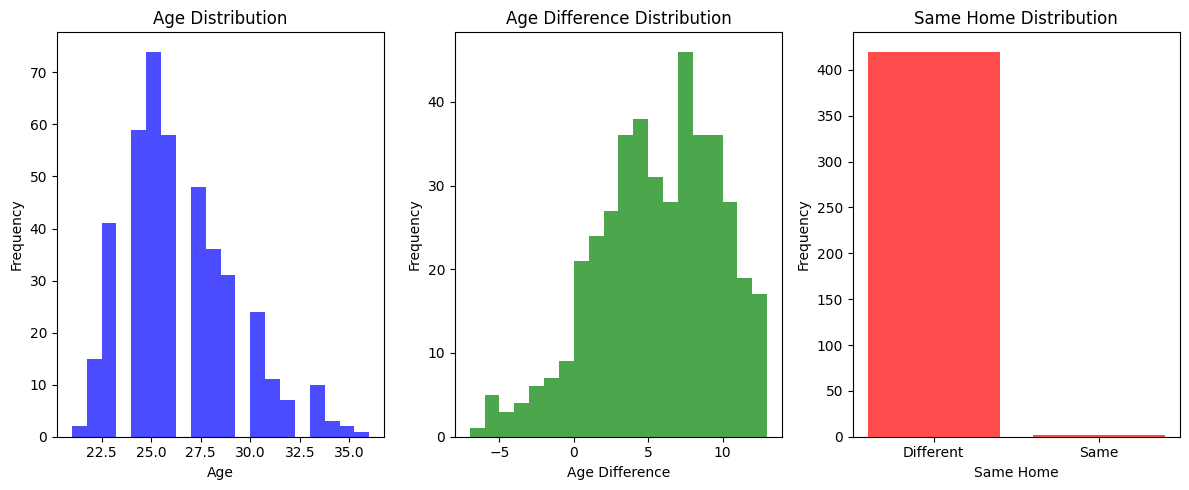

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Plot feature distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.hist(contestants_df['Age'], bins=20, color='blue', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(contestants_df['Age Difference'], bins=20, color='green', alpha=0.7)
plt.title('Age Difference Distribution')
plt.xlabel('Age Difference')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.bar([0, 1], contestants_df['Same Home'].value_counts(), color='red', alpha=0.7)
plt.xticks([0, 1], ['Different', 'Same'])
plt.title('Same Home Distribution')
plt.xlabel('Same Home')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



In [ ]:
# Define the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [ ]:
# Print model summary
print("Model Summary:")
model.summary()



Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
9/9 [==============================] - 1s 35ms/step - loss: 0.2701 - accuracy: 0.9517 - val_loss: 0.2099 - val_accuracy: 0.9559
Epoch 2/10
9/9 [==============================] - 0s 6ms/step - loss: 0.1932 - accuracy: 0.9628 - val_loss: 0.2245 - val_accuracy: 0.9559
Epoch 3/10
9/9 [==============================] - 0s 7ms/step - loss: 0.1875 - accuracy: 0.9628 - val_loss: 0.1935 - val_accuracy: 0.9559
Epoch 4/10
9/9 [==============================] - 0s 8ms/step - loss: 0.1643 - accuracy: 0.9628 - val_loss: 0.1778 - val_accuracy: 0.9559
Epoch 5/10
9/9 [==============================] - 0s 8ms/step - loss: 0.1612 - accuracy: 0.9628 - val_loss: 0.1779 - val_accuracy: 0.9559
Epoch 6/10
9/9 [==============================] - 0s 7ms/step - loss: 0.1611 - accuracy: 0.9628 - val_loss: 0.1776 - val_accuracy: 0.9559
Epoch 7/10
9/9 [==============================] - 0s 9ms/step - loss: 0.1609 - accuracy: 0.9628 - val_loss: 0.1784 - val_accuracy: 0.9559
Epoch 8/10
9/9 [=================

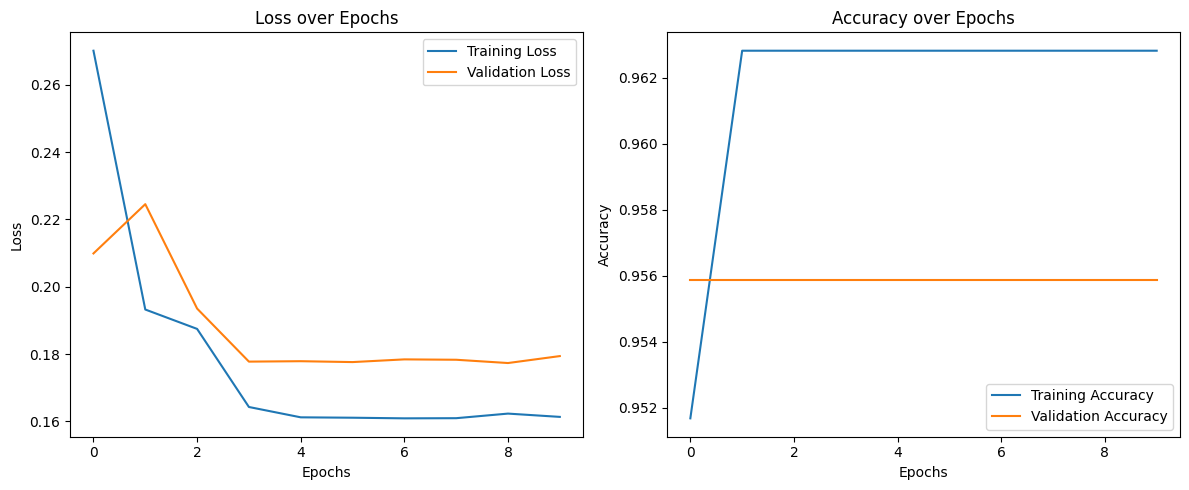

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss', test_loss)
print('Test Accuracy', test_acc)



3/3 [==============================] - 0s 5ms/step - loss: 0.1863 - accuracy: 0.9529
Test Loss 0.18630722165107727
Test Accuracy 0.9529411792755127


In [ ]:
# Make predictions
predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)




3/3 [==============================] - 0s 5ms/step


In [ ]:
# Print predictions
print("Predictions on Test Set")
print(predictions[:5])



Predictions on Test Set
[[0.02528317]
 [0.03863592]
 [0.00580877]
 [0.04563499]
 [0.03497979]]


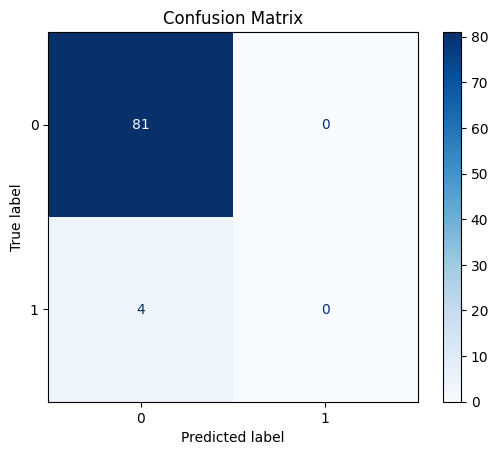

In [ ]:
# Confusion Matrix
unique_labels = np.unique(target)
cm = confusion_matrix(y_test, predictions_binary)
cmd = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



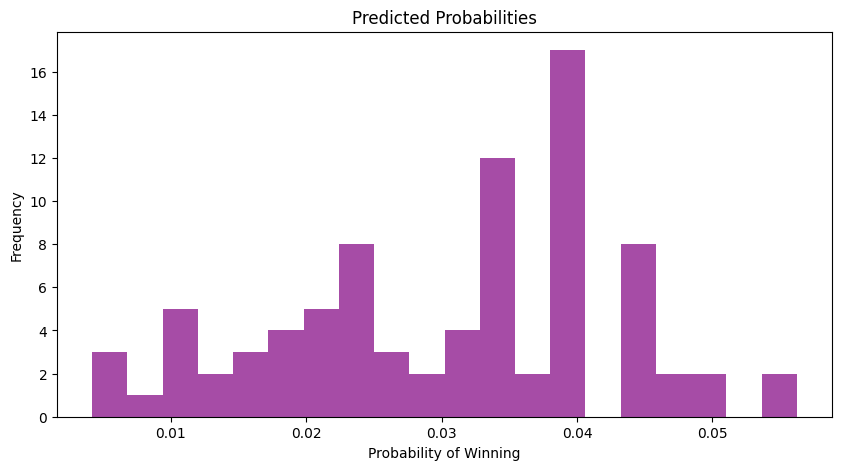

In [ ]:
# Predicted probabilities
plt.figure(figsize=(10, 5))
plt.hist(predictions, bins=20, color='purple', alpha=0.7)
plt.title('Predicted Probabilities')
plt.xlabel('Probability of Winning')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Create SparkSession
spark = SparkSession.builder \
    .appName("Bachelor") \
    .getOrCreate()


In [ ]:
# Generate predictions and actual values (replace this with your actual prediction code)
predictions = [0.2, 0.6, 0.8, 0.3, 0.9]
y_test = [0, 1, 0, 0, 1]


In [ ]:
# Convert pandas DataFrame to Spark DataFrame
predictions_df = pd.DataFrame({'Prediction': predictions, 'Actual': y_test})
predictions_df_spark = spark.createDataFrame(predictions_df)


In [ ]:
# Store prediction results in Parquet format
predictions_df_spark.write.parquet('path_to_predictions.parquet', mode='overwrite')


In [ ]:
# Load prediction results into Spark DataFrame using Spark SQL
predictions_df_spark = spark.read.parquet('path_to_predictions.parquet')


In [ ]:
# Register the DataFrame as a temporary view
predictions_df_spark.createOrReplaceTempView("predictions")

# Execute SQL queries on the Spark DataFrame
result = spark.sql("SELECT * FROM predictions WHERE Prediction > 0.5")
result.show()

+----------+------+
|Prediction|Actual|
+----------+------+
|       0.8|     0|
|       0.9|     1|
|       0.6|     1|
+----------+------+

